In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load the MNIST dataset

number: 5


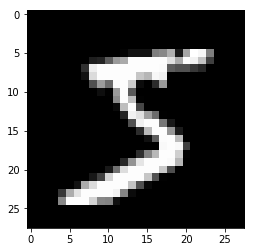

In [3]:
# read images
with open('./Data/train-images.idx3-ubyte', 'rb') as f:
    # procedure:
    # -> read data
    # -> to list
    # -> ignore first 16 bytes
    # -> to np.ndarray
    # -> reshape data
    imgs = np.array(list(f.read())[16:]).reshape([60000, 28, 28])

# read labels
with open('./Data/train-labels.idx1-ubyte', 'rb') as f:
    labels = np.array(list(f.read())[8:])

# show the first label and image
print('number:', labels[0])
plt.imshow(imgs[0], cmap='gray')
plt.show()

# reshape the image data from 3-D to 2-D required to feed NN
imgs = imgs.reshape([60000, 28*28]).astype('float32') # 784
# split into training set and testing set
imgs_test = imgs[50000:]
imgs = imgs[:50000]

- One-hot encoding

In [4]:
labels_onehot = list()
for i in range(labels.shape[0]):
    # create zero array [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    onehot = np.zeros(10)
    # if label == 5  ->  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
    onehot[labels[i]] = 1
    labels_onehot.append(onehot)
labels_onehot = np.array(labels_onehot).astype('float32')

# split into training set and testing set
labels_onehot_test = labels_onehot[50000:]
labels_onehot = labels_onehot[:50000]

In [5]:
imgs.shape, labels_onehot.shape

((50000, 784), (50000, 10))

# Build the network

## *The overall structure*

<img src="./imgs/DNN_ALL_mnist.png" width="60%" height="60%">

## <span style="color:blue">Dropout
- <span style="color:blue">Strength: prevent overfitting
- <span style="color:blue">Weakness: reduce the training efficiency</span>

### Define the hyperparameter

In [6]:
epoch = 3
batch_size = 200
n_inp = 784
n_layer1 = 1024
n_layer2 = 1024
n_out = 10
l_r = 1e-3
keep_prob = .8 # the probability for dropout function

## *<span style="color:red">●Step 1</span>: Construct the input and real label holders*

<img src="./imgs/DNN_xy_mnist.png" width="60%" height="60%">

In [7]:
x = tf.placeholder(tf.float32, shape=[None, n_inp], name='input')
y = tf.placeholder(tf.float32, shape=[None, n_out], name='output')

## *<span style="color:red">●Step 2</span>:Define the weight and bias creating function*

In [8]:
def _weight(shape):
    initial = tf.truncated_normal(mean=0, stddev=.5, shape=shape)
    return tf.Variable(initial)
def _bias(shape):
    initial = tf.constant(1, shape=shape, dtype=tf.float32)
    return tf.Variable(initial)

## *<span style="color:red">●Step 3</span>:Input layer to the 1st hidden layer*

<img src="./imgs/DNN_input2first_mnist.png" width="60%" height="60%">

In [9]:
w1 = _weight([n_inp, n_layer1])
b1 = _bias([n_layer1])
# procedure:
# -> matrix multiply: input and weight of layer 1
# -> add the bias
# -> activation function: relu
# -> dropout to prevent over-fitting
layer1 = tf.nn.dropout(tf.nn.relu(tf.matmul(x, w1) + b1), keep_prob=keep_prob)

## *<span style="color:red">●Step 4</span>: The 1st layer to the 2nd hidden layer*

<img src="./imgs/DNN_first2second_mnist.png" width="60%" height="60%">

In [10]:
w2 = _weight([n_layer1, n_layer2])
b2 = _bias([n_layer2])
layer2 = tf.nn.dropout(tf.nn.relu(tf.matmul(layer1, w2) + b2), keep_prob=keep_prob)

## *<span style="color:red">●Step 5</span>: The 2nd layer to the output layer*

<img src="./imgs/DNN_second2output_mnist.png" width="60%" height="60%">

In [11]:
w_out = _weight([n_layer2, n_out])
b_out = _bias([n_out])
_pred = tf.matmul(layer2, w_out) + b_out
pred = tf.nn.softmax(_pred, name='prediction')

## *<span style="color:red">●Step 6</span>: The cost function and optimizer*

<img src="./imgs/DNN_cost_mnist.png" width="60%" height="60%">

In [12]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=_pred, labels=y))
# calculate the accuracy by the fed label and predicted result over the input batch data
accu = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1)), tf.float32))
op = tf.train.AdamOptimizer(l_r)
update_step = op.minimize(loss)

## *<span style="color:red">●Step 7</span>: Open a new NN session and initialize the variables*

In [13]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

## *<span style="color:red">●Step 8</span>: Training and record the loss and accuracy*

In [14]:
loss_list = list()
accu_list = list()
loss_list_test = list()
accu_list_test = list()
for epo in range(epoch):
    l_list = list()
    a_list = list()
    for i in range(int(len(imgs)/batch_size)):
        batch_x = imgs[i*batch_size:i*batch_size+batch_size]
        batch_y = labels_onehot[i*batch_size:i*batch_size+batch_size]
        feed_dict = {x:batch_x, y:batch_y}
        _, l, a = sess.run([update_step, loss, accu], feed_dict=feed_dict)
        l_list.append(l)
        a_list.append(a)
    loss_list.append(np.mean(l_list))
    accu_list.append(np.mean(a_list))
    batch_x = imgs_test
    batch_y = labels_onehot_test
    feed_dict = {x:batch_x, y:batch_y}
    l, a = sess.run([loss, accu], feed_dict=feed_dict)
    loss_list_test.append(l)
    accu_list_test.append(a)
    print('Epoch:', epo+1,
          ', train loss:', loss_list[epo],
          ', train accu:', accu_list[epo],
          ', test loss:', l,
          ', test accu:', a)

Epoch: 1 , train loss: 19971.2 , train accu: 0.76588 , test loss: 6696.03 , test accu: 0.8833
Epoch: 2 , train loss: 5333.03 , train accu: 0.8902 , test loss: 3821.96 , test accu: 0.9112
Epoch: 3 , train loss: 3137.79 , train accu: 0.9145 , test loss: 2822.36 , test accu: 0.9233
